In [1]:
using IonSim
using QuantumOptics

In [2]:
# Construct the system
C = Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])
L1 = Laser(ϕ=π); L2 = Laser()  # note the π-phase between L1/L2
chain = LinearChain(ions=[C, C],
                    comfrequencies=(x=3e6, y=3e6, z=2.5e5),
                    selectedmodes=(;z=[1]))
chamber = Chamber(  B=6e-4,
                    Bhat=(x̂ + ẑ)/√2,
                    iontrap=chain,
                    lasers=[L1, L2]);

# Set the laser parameters
ϵ = 10e3
d = 350  
# correct for single-photon coupling to sidebands
wavelength_from_transition!(L1, C, ("S", "D"), chamber)
wavelength_from_transition!(L2, C, ("S", "D"), chamber)
detuning!(L1, modes(chamber)[1].ν + ϵ - d) 
detuning!(L2, -modes(chamber)[1].ν - ϵ + d)
L1.k = L2.k = ẑ # old
L1.ϵ = L2.ϵ = x̂ # old

# set 'resonance' condition: ηΩ = 1/2ϵ
η = abs(lambdicke(modes(chamber)[1], C, L1)) # old
E = intensity_from_pitime!(1, η/ϵ, 1, ("S", "D"), chamber)
Ω = t -> t < 20 ? E * sin(2π * t / 80)^2 : E  # ampl. ramp # old
L1.I = L2.I = Ω

# Build Hamiltonian
h = hamiltonian(chamber, timescale=1e-6)

# Solve
tspan = 0:.1:220
# t, sol = timeevolution.schroedinger_dynamic(tspan, C["S"] ⊗ C["S"] ⊗ mode[0], h); # old
t, sol = timeevolution.schroedinger_dynamic(tspan, ions(chamber)[1]["S"] ⊗ ions(chamber)[2]["S"] ⊗ modes(chamber)[1][0], h) # not fully implemented

┌ Warning: Some ions point to the same thing. Making copies.
└ @ IonSim ~/.julia/packages/IonSim/UekVf/src/iontraps.jl:166


([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  219.1, 219.2, 219.3, 219.4, 219.5, 219.6, 219.7, 219.8, 219.9, 220.0], Ket{CompositeBasis{Vector{Int64}, Tuple{IonInstance{:Ca40}, IonInstance{:Ca40}, VibrationalMode}}, Vector{ComplexF64}}[Ket(dim=44)
  basis: [⁴⁰Ca
 ⊗ ⁴⁰Ca
 ⊗ VibrationalMode(ν=250000.0, axis=ẑ, N=10)]
 1.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
     ⋮
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im
 0.0 + 0.0im, Ket(dim=44)
  basis: [⁴⁰Ca
 ⊗ ⁴⁰Ca
 ⊗ VibrationalMode(ν=250000.0, axis=ẑ, N=10)]
 0.9999999999061514 + 5.752e-14im
    9.6736816592e-6 + 0.0im
    9.6736816592e-6 + 0.0im
       9.039198e-11 + 5.752e-14im
         4.4054e-13 - 1.8973e-13im
    1.5572206388e-7 - 1.31596317335e-6im
    1.5572206388e-7 - 1.31596317335e-6im
        2.86863e-12

/Users/jspark971/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


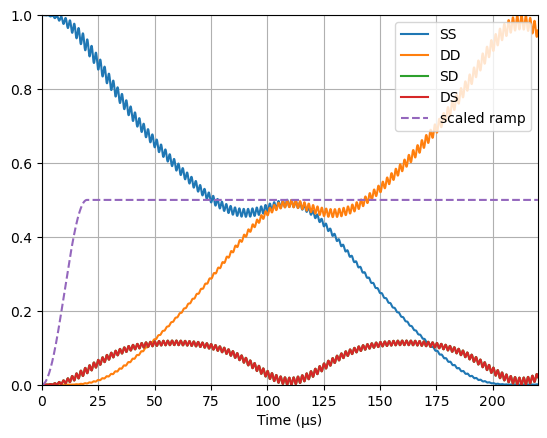

In [18]:
# Plotting
import PyPlot
const plt = PyPlot

SS = expect(ionprojector(chamber, "S", "S"), sol)
DD = expect(ionprojector(chamber, "D", "D"), sol)
SD = expect(ionprojector(chamber, "S", "D"), sol)
DS = expect(ionprojector(chamber, "D", "S"), sol)
plt.plot(t, SS, label="SS")
plt.plot(t, DD, label="DD")
plt.plot(t, SD, label="SD")
plt.plot(t, DS, label="DS")
plt.plot(t, @.(Ω(t) / 2E), ls="--", label="scaled ramp")
plt.legend(loc=1)
plt.xlim(t[1], t[end])
plt.ylim(0, 1)
plt.xlabel("Time (μs)")
plt.grid()